# Increasing WellCo Retention Rate with Vi Engage

In [5]:
from utils.data_loaders import get_features_df, get_churn_labels_df

In [7]:
import argparse
import os

import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from artifacts import ARTIFACTS_DIRECTORY_PATH
from compose.build_pipelines import build_supervised_pipeline
from data.raw.raw_data_column_names import MEMBER_ID_COLUMN, OUTREACH_COLUMN, CHURN_COLUMN, SIGNUP_DATE_COLUMN
from preprocessing.members_matching import matching_members, fit_propensity_model, match_on_propensity, \
    validate_matching_quality
from utils.data_loaders import get_features_df, get_churn_labels_df
from sklift.models.models import TwoModels
from xgboost import XGBClassifier

import plotly.io as pio

from utils.explain_model import plot_logistic_regression_importance
from utils.plot_utils import plot_feature_correlation_heatmap, plot_calibration_curve
from utils.metrics import c_for_benefit_from_pairs

In [22]:
pio.renderers.default = "notebook_connected"

In [8]:
features_version = 'v2'

In [9]:
features_df = get_features_df(features_version=features_version)
churn_labels_df = get_churn_labels_df()

In [10]:
features_with_labels = features_df.merge(
    churn_labels_df,
    on=MEMBER_ID_COLUMN,
    how='left'
)

In [11]:
X = features_with_labels.drop(
    columns=[
        MEMBER_ID_COLUMN,
        OUTREACH_COLUMN,
        CHURN_COLUMN,
        SIGNUP_DATE_COLUMN,
    ],
    errors="ignore",
)
y = features_with_labels[CHURN_COLUMN]
t = features_with_labels[OUTREACH_COLUMN]
stratify_col = features_with_labels[[CHURN_COLUMN, OUTREACH_COLUMN]].astype(int).astype(str).agg('_'.join, axis=1)

In [12]:
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, t,
    test_size=0.2,
    stratify=stratify_col,
    random_state=42
)

In [13]:
X_train_m, t_train_m, y_train_m, matched_idx_train, pairs_train = matching_members(X_train, t_train, y_train)

Matched train size: 3862 (pairs: 1931, treated: 1931, control: 1931)


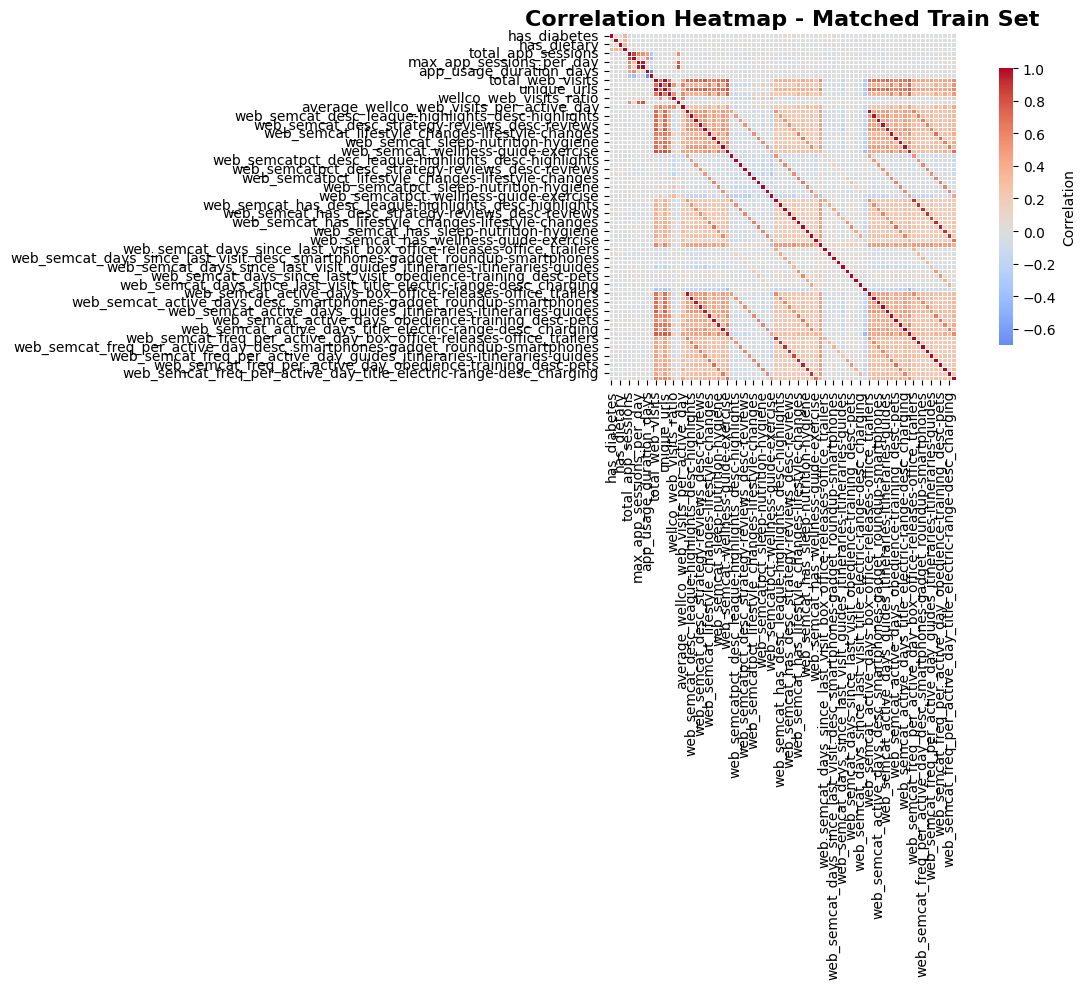

In [14]:
plot_feature_correlation_heatmap(X_train_m, "Correlation Heatmap - Matched Train Set")

## Churn Risk Estimator

In [25]:
baseline_model_name = f'baseline_logistic_regression_model'

baseline_pipeline = build_supervised_pipeline()
baseline_pipeline.fit(X_train_m, y_train_m)

y_pred = baseline_pipeline.predict(X_test)
y_proba = baseline_pipeline.predict_proba(X_test)[:, 1]

In [26]:
print("AUC:", roc_auc_score(y_test, y_proba))
print("ROC AUC on Train:", roc_auc_score(y_train_m, baseline_pipeline.predict_proba(X_train_m)[:, 1]))

AUC: 0.6162252876724316
ROC AUC on Train: 0.6875214377976566


In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.64      0.73      1588
           1       0.27      0.53      0.36       403

    accuracy                           0.62      1991
   macro avg       0.56      0.58      0.54      1991
weighted avg       0.73      0.62      0.65      1991



In [28]:
importance_df, fig = plot_logistic_regression_importance(
    model=baseline_pipeline,
    X_train=X_train_m,
    output_dir=os.path.join(ARTIFACTS_DIRECTORY_PATH, "explainability"),
    top_n=30,
    model_name="baseline_logistic_regression"
)
fig

Saved logistic regression feature importances to: C:\Users\labca\PycharmProjects\vi-demo\artifacts\explainability\baseline_logistic_regression_feature_importance.csv


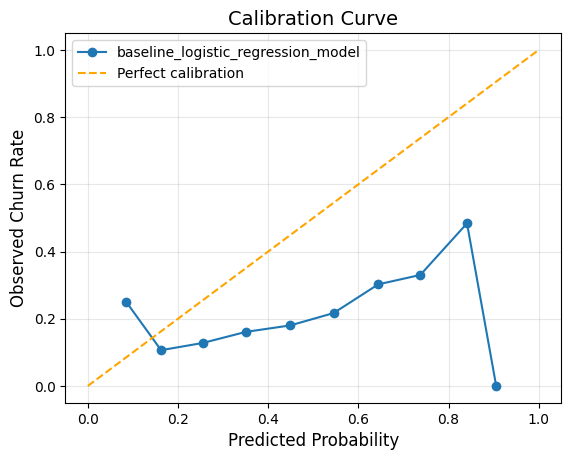

In [29]:
plot_calibration_curve(
    y_ground_truth=y_test,
    y_estimated_probability=y_proba,
    model_name=baseline_model_name,
)

## Uplift

In [30]:
treatment_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
    ),
)

control_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
    ),
)

In [32]:
treatment_pipeline.fit(
    X_train_m[t_train_m == 1],
    y_train_m[t_train_m == 1],
)

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [33]:
control_pipeline.fit(
    X_train_m[t_train_m == 0],
    y_train_m[t_train_m == 0],
)

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [39]:
treatment_proba_test = treatment_pipeline.predict_proba(X_test)[:, 1]
control_proba_test = control_pipeline.predict_proba(X_test)[:, 1]

In [40]:
uplift_test = control_proba_test - treatment_proba_test

In [48]:
predicted_uplift_test = pd.DataFrame({
    MEMBER_ID_COLUMN: features_with_labels.loc[X_test.index, MEMBER_ID_COLUMN].values,
    "uplift": uplift_test
})
predicted_uplift_test.sort_values(by='uplift', ascending=False, inplace=True)

predicted_uplift_test

,member_id,uplift
1163,234,0.582433
20,8460,0.561834
1037,297,0.549649
271,6247,0.522922
693,2869,0.516404
...,...,...
1788,9147,-0.506332
254,5081,-0.507495
925,9080,-0.533882
1623,8345,-0.537816


In [44]:
treatment_proba_all = treatment_pipeline.predict_proba(X)[:, 1]
control_proba_all = control_pipeline.predict_proba(X)[:, 1]

In [46]:
uplift_all = control_proba_all - treatment_proba_all

In [47]:
predicted_uplift_all = pd.DataFrame({
    MEMBER_ID_COLUMN: features_with_labels[MEMBER_ID_COLUMN],
    "uplift": uplift_all
})
predicted_uplift_all.sort_values(by='uplift', ascending=False, inplace=True)
predicted_uplift_all['rank'] = np.arange(1, len(predicted_uplift_all) + 1)
predicted_uplift_all.rename(columns={'uplift': 'prioritization_score'}, inplace=True)


predicted_uplift_all

,member_id,prioritization_score,rank
439,444,0.615820,1
3663,3686,0.593763,2
232,234,0.582433,3
8414,8460,0.561834,4
294,297,0.549649,5
...,...,...,...
7193,7230,-0.600433,9949
8635,8682,-0.614717,9950
5499,5528,-0.649426,9951
9634,9682,-0.661256,9952


## Optimal N 

### Same Budget Optimized

### Optimizing N without Budget Limit 

In [ ]:
order_test = np.argsort(-uplift_test)
y_order_test = y_test.values[order_test]
t_order_test = t_test.values[order_test]